<a href="https://colab.research.google.com/github/comp0088/colab-wip/blob/main/comp88_lab7%2Bsolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP0088 Lab Assignment 7



## Introduction

In this week's lab assignment we move on to **unsupervised learning**, where we are attempting to discover underlying structure in data without having any labels to guide us. Perhaps the two most common approaches to this are **clustering**, which is analogous to classification, and **dimensionality reduction**, analogous to regression. Here you'll implement the **$k$-means algorithm** for clustering and **principal components analysis** for (linear) dimensionality reduction.

Examples of the kinds of plots that will be produced by your finished code are shown below. Plotting code is provided, so your plots should look pretty similar, though there is also some randomisation.

![example of completed plots](https://comp0088.github.io/assets/colab/week_7.jpg)


## Setting Up

As usual, this notebook makes use of the NumPy library for numerical computing and the Matplotlib library for plotting, so we need to import them. We'll also import the [imageio](https://imageio.readthedocs.io/en/stable/) package that we'll use to load a test image for Tasks 2 and 3.

In [2]:
import numpy as np
import numpy.random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import imageio.v3 as iio

Fetch some shared COMP0088 lab code and data from the module GitHub:

In [3]:
# load lab code and resources
!git clone https://github.com/comp0088/shared.git comp0088

# at the moment this is all we care about
import comp0088.utils as utils

Cloning into 'comp0088'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 10.81 KiB | 10.81 MiB/s, done.
Resolving deltas: 100% (1/1), done.


Set up some items for later use, including some random synthetic data we'll use for clustering.

In [4]:
# the usual random number generator
shared_rng = numpy.random.default_rng()

# for initial tests of the clustering, we'll use synthetic data
# randomly generated from a very simple 2D mixture model
CLUSTERS = [ ((3,3), 1),
             ((-3,-3), 1),
             ((-3, 3), 0.5),
             ((3, -3), 1.5) ]
NUM_CLUSTERS = 3
SAMPLES_PER_CLUSTER = 25

def generate_gaussian_samples(clusters=CLUSTERS[:NUM_CLUSTERS],
                              num_samples=SAMPLES_PER_CLUSTER,
                              rng=shared_rng):
    """
    Create a simple dataset drawn from an equal mix of
    gaussians with specified means.

    # Arguments:
        clusters: a list of 2-tuples, where the first element is the
            (multi-dimensional) mean of the gaussian to draw from and
            the second is its (spherical) variance.
        num_samples: how many samples to generate for each cluster
            (the same number for each)
        rng: a random number generator to draw from

    # Returns:
        X: a design matrix of generated data
    """
    results = []
    for cluster in clusters:
        mean = np.array(cluster[0])
        cov = np.eye(len(mean)) * cluster[1]
        results.append(rng.multivariate_normal(mean=mean, cov=cov, size=num_samples))
    return np.concatenate(results)

CLUSTER_TEST = generate_gaussian_samples()


# Task 1: $k$-Means Clustering

In a **clustering** problem, we attempt to divide an unlabelled dataset into groups, such that samples within a group are more similar to each other than they are to samples in other groups. The group membership can be thought of as similar to a class label in a classification problem, but we must infer the labels just from the distribution of the data rather than having any known examples to learn from.

There are many ways to do clustering, but one of the simplest and most common is by using the **$k$-means** algorithm. As with many unsupervised learning approaches, this involves starting with an initial guess, using that guess to make predictions and then using those predictions to improve the guess, iteratively refining back and forth until we settle on values that we're happy with.

The steps in this case are:

* Initialise $k$ cluster centroids
* Repeat:
  * Assign samples to their nearest cluster centroid
  * Estimate centroid of each cluster as the mean of all its assigned samples
* Until: cluster assignments do not change

(This is a simple instance of an **expectation-maximisation** algorithm, which we will consider in more detail next week.)

Note that the hyperparameter $k$ has to be specified externally, it is not learned as part of the algorithm.

## 1.1 Compute the "within cluster sum of squares" metric

As mentioned in lecture 8.2, $k$-means can be formulated as the minimisation of a loss known as the **within cluster sum of squares** or WCSS:

$$\text{WCSS} = \frac{1}{n} \sum_i^n \| \mathbf{x}_i - \mathbf{c}_{a_i} \|^2 $$

where $\mathbf{c}_{a_i}$ is the **centroid** of the cluster to which sample $\mathbf{x}_i$ is assigned. (The division by $n$ makes it a *mean* value — this is not always done, but it makes the loss more comparable.)

In practice we do not use this loss directly in the fitting process, but we will use it to monitor the progress of minimisation.

Implement the body of the `compute_wcss` function in the cell below. (Use the [np.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) function to compute distances between vectors.)


In [5]:
def compute_wcss(X, centroids, assignments):
    """
    Compute the within cluster sum of squares (WCSS).

    # Arguments:
        X: input design matrix of shape (num_samples, num_features).
        centroids: array of shape (k, num_features) containing the centroids
            for each cluster.
        assignments: vector of length num_samples containing the cluster
            assignments for each row in data. (Assignments are integers in
            the range 0 to k-1, indexing rows in centroids.)

    # Returns:
        wcss: the mean WCSS across all clusters.
    """

    # TODO: implement this
    #return None

    # --------

    # this is just a direct translation of the above formula into NumPy code
    # instead of looping the sum we build a matrix of all the centroids,
    # then subtract and compute all the norms in one go
    return np.sum(np.linalg.norm(X - centroids[assignments,:], axis=1)**2)/X.shape[0]


## 1.2 Choose initial centroids

As for most iterative methods, we need to choose starting values for the parameters that we want to fit — in this case, that's the cluster centroids. There are several possible ways of doing so. Here you'll implement two, both pretty simple:

* `naive`: This initialisation is *very* naive, and also potentially problematic, so it is seldom used in practice. But it is easy to implement and worth at least trying out. Here we just pick the initial centroids at random from a uniform distribution over the feature ranges.
* `forgy`: This initialisation is just as easy and much more common. The choice is again random, but instead of choosing from the feature range we restrict ourselves to points that are actually present in the training set. Be sure not to sample with replacement, though — you want all your centroids to be distinct.


In [6]:
def initialise_centroids ( X, k, method='forgy', rng=shared_rng ):
    """
    Choose initial centroids appropriate to the data.

    # Arguments:
        X: input design matrix of shape (num_samples, num_features).
        k: number of clusters to initialise
        method: how to choose the centroids, either 'naive' or 'forgy'

    # Returns:
        centroids: array of shape (k, num_features) containing the chosen centroids
    """

    # TODO: implement this
    #return None

    # --------
    if method=='forgy':
        return rng.choice(X, k, replace=False)
    else:
        # min and max here return vectors, getting the range of each feature
        lo = np.min(X, axis=0)
        scale = np.max(X, axis=0) - lo

        # generate in [0,1] then scale and offset for each feature
        return rng.uniform(size=(k, X.shape[1])) * scale + lo


## 1.3 Assign data to clusters

Implement the `assign_to_clusters` function in the code cell below to perform the assignment step of the algorithm.

You are given the cluster centroids, so for each data point you just need to choose the one that is closest to it. (Assignments are integer indices of rows in the `centroids` array.)

Although this is simple, there is potential for it to be very slow if done naively. This shouldn't be an issue for the simple test here in Task 1, but it may become one in Task 2, where the dataset has many more points. See if you can take advantage of NumPy vectorisation to do this efficiently. One thing to bear in mind is that in general $k \ll n$ — ie, there will be many fewer centroids than data points.

You can again use [np.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) to compute distances.

In [7]:
def assign_to_clusters (X, centroids):
    """
    Choose the nearest cluster centroid for each data point.

    # Arguments:
        X: input design matrix of shape (num_samples, num_features)
        centroids: array of shape (k, num_features) containing the
            cluster centroids to choose among

    # Returns:
        assignments: vector of length num_samples containing the cluster assignments
    """

    # TODO: implement this
    #return None

    # --------

    # we'll compute distances to each centroid for all points in one go
    # and then compute the argmin for all points in one go too

    # allocate an array for the distances to live in
    dists = np.zeros((X.shape[0], centroids.shape[0]))

    # one centroid at time
    for ii in range(centroids.shape[0]):
        # all distances in one go
        dists[:,ii] = np.linalg.norm(X - centroids[ii,:], axis=1)

    # find minimum index for every row
    return np.argmin(dists, axis=1)

## 1.4 Compute centroids

Implement the `compute_centroids` function in the code cell below to perform the update step of the algorithm.

You are given the data and assignments. The new centroids should just be the means of all points assigned to each cluster.

Note that it is possible for a cluster to have no points assigned at all, eg if the initial choice of centroids was poor. (This is why `k` is provided explicitly as an argument rather than just being inferred from the contents of `assignments`.) In this case, you might want to supply some non-colliding value.

In [8]:
def compute_centroids (X, assignments, k, rng=shared_rng):
    """
    Choose the nearest cluster centroid for each data point.

    # Arguments:
        X: input design matrix of shape (num_samples, num_features)
        assignments: vector length num_samples containing the cluster assignments
        k: the total number of centroids
        rng: an instance of numpy.random.Generator

    # Returns:
        centroids: array of shape (k, num_features) containing the new centroids
    """

    # TODO: implement this
    #return None

    # --------

    centroids = np.zeros((k, X.shape[1]))
    for ii in range(k):
        # extract all matching points
        clust = X[assignments==ii,:]

        # if we're unlucky there might be centroids with no assigned points
        if len(clust):
            # if there's data just calculate the mean
            centroids[ii,] = np.mean(clust, axis=0)
        else:
            # fill in with some naive random nonsense
            # to minimise chance of collision
            lo = np.min(X, axis=0)
            scale = np.max(X, axis=0) - lo
            centroids[ii,:] = rng.uniform(size=X.shape[1]) * scale + lo

    return centroids

## 1.5 Perform $k$-means clustering

Implement the `k_means_cluster` function in the cell below to put it all together. Most of the work here has already been done in the previous tasks, so this will mostly be a matter of iteratively calling the previous functions.

Keep track of the loss as you go along so that we can visualise the convergence later. You may also find it useful to print some messages along the way so that you can see what it's doing, eg if it's taking a long time in Task 2.

In [9]:
def k_means_cluster(X, k=3, init='forgy', max_iter=500, rng=shared_rng):
    """
    Iteratively perform k-means clustering on a dataset until
    converged or maximum iterations reached.

    # Arguments:
        X: input design matrix of shape (num_samples, num_features)
        k: the number of clusters to assign the data to
        init: the initialisation method (one of 'forgy', 'naive')
        max_iter: the maximum number of iterations to run the algorithm
        rng: an instance of numpy.random.Generator

    # Returns:
        assignments: vector of length num_samples giving cluster assignments
            for each data sample
        centroids: the final cluster centroids
        loss_history: a vector of WCSS values over the course of fitting
    """

    # TODO: implement this
    #return None, None, None

    # --------
    print(f'initialising {k} centroids')
    centroids = initialise_centroids(X, k, method=init, rng=rng)
    print('assigning initial clusters')
    assignments = assign_to_clusters(X, centroids)
    loss_history = [compute_wcss(X, centroids, assignments)]

    for ii in range(max_iter):
        print(f'iteration {ii+1}')

        # do the k-means steps
        centroids = compute_centroids(X, assignments, k, rng)
        new_assignments = assign_to_clusters(X, centroids)

        # keep track of the loss
        loss_history.append(compute_wcss(X, centroids, assignments))

        # check for convergence
        if np.all(new_assignments == assignments): break

        # update the assignments and repeat
        assignments = new_assignments

    return assignments, centroids, np.array(loss_history)


## → Run Task 1

Execute the code cell below to run your k-means function on some simple random test data and plot the results. By default the test data will be generated with 3 gaussian clusters, and the code below tries fitting with 2, 3 and 4.

How does each perform? Are the results what you would expect? Are the results consistent if the you run the test several times?


initialising 2 centroids
assigning initial clusters
iteration 1
iteration 2
initialising 3 centroids
assigning initial clusters
iteration 1
iteration 2
iteration 3
initialising 4 centroids
assigning initial clusters
iteration 1
iteration 2
iteration 3


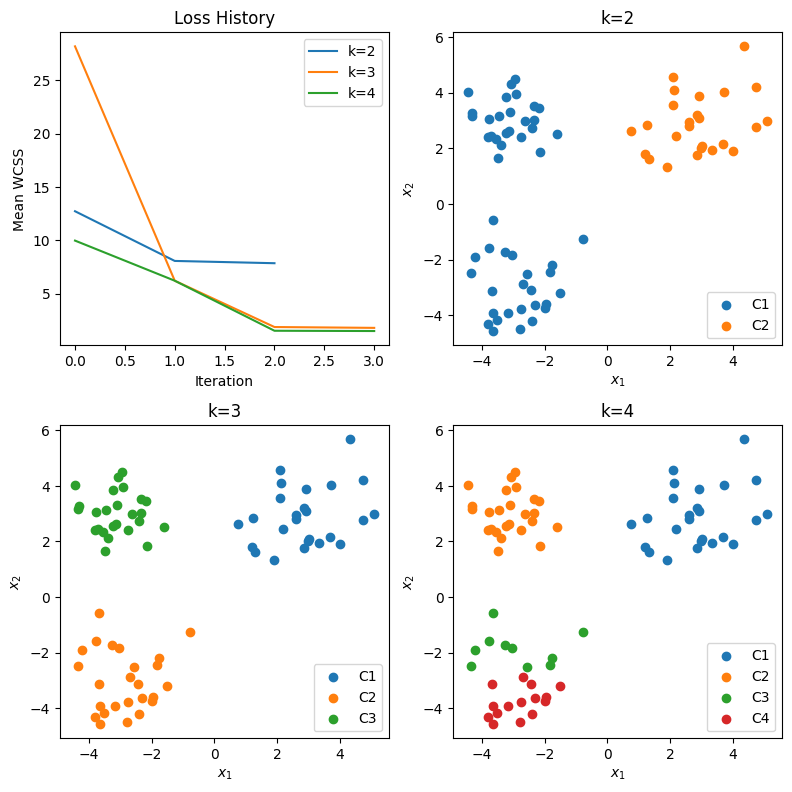

In [10]:
a2, c2, l2 = k_means_cluster(CLUSTER_TEST, 2)
a3, c3, l3 = k_means_cluster(CLUSTER_TEST, 3)
a4, c4, l4 = k_means_cluster(CLUSTER_TEST, 4)

fig = plt.figure(figsize=(8, 8))
axs = fig.subplots(ncols=2, nrows=2)

axs[0,0].plot(l2, label="k=2")
axs[0,0].plot(l3, label="k=3")
axs[0,0].plot(l4, label="k=4")
axs[0,0].set_title('Loss History')
axs[0,0].set_xlabel('Iteration')
axs[0,0].set_ylabel('Mean WCSS')
axs[0,0].legend()

axs[0,1].scatter(CLUSTER_TEST[a2==0,0], CLUSTER_TEST[a2==0,1], label="C1")
axs[0,1].scatter(CLUSTER_TEST[a2==1,0], CLUSTER_TEST[a2==1,1], label="C2")
axs[0,1].set_title('k=2')
axs[0,1].set_xlabel('$x_1$')
axs[0,1].set_ylabel('$x_2$')
axs[0,1].legend()

axs[1,0].scatter(CLUSTER_TEST[a3==0,0], CLUSTER_TEST[a3==0,1], label="C1")
axs[1,0].scatter(CLUSTER_TEST[a3==1,0], CLUSTER_TEST[a3==1,1], label="C2")
axs[1,0].scatter(CLUSTER_TEST[a3==2,0], CLUSTER_TEST[a3==2,1], label="C3")
axs[1,0].set_title('k=3')
axs[1,0].set_xlabel('$x_1$')
axs[1,0].set_ylabel('$x_2$')
axs[1,0].legend()

axs[1,1].scatter(CLUSTER_TEST[a4==0,0], CLUSTER_TEST[a4==0,1], label="C1")
axs[1,1].scatter(CLUSTER_TEST[a4==1,0], CLUSTER_TEST[a4==1,1], label="C2")
axs[1,1].scatter(CLUSTER_TEST[a4==2,0], CLUSTER_TEST[a4==2,1], label="C3")
axs[1,1].scatter(CLUSTER_TEST[a4==3,0], CLUSTER_TEST[a4==3,1], label="C4")
axs[1,1].set_title('k=4')
axs[1,1].set_xlabel('$x_1$')
axs[1,1].set_ylabel('$x_2$')
axs[1,1].legend()

fig.tight_layout(pad=1)

# Task 2: Image colour quantisation

One task that a clustering method such as $k$-means can be used for is **vector quantisation**, mapping samples with a continuous range of values to a number of discrete levels.

This can be used as a compression technique for image and video data, allowing individual pixels to be stored as much smaller data types by sacrificing some colour resolution. Indexed colour image formats like GIF are no longer as ubiquitous as they were in the 1990s, but they are still in use today, and colour quantisation plays a role in many video compression schemes. Quantisation is also often used for creative effects like [posterisation](https://en.wikipedia.org/wiki/Posterization).

## 2.1 Implement image colour quantisation

Implement the `quantise_image` function in the cell below to reduce the number of colours in an image.

The bulk of the processing here is already provided by the `k_means_cluster` function you wrote Task 1.5. You'll need to reshape the supplied image to conform to the design matrix ordering that the clustering function expects, and then create and return a new image that has its pixels set to the quantised colours. (Don't alter the original image pixels.)

Note that the `dtype` of the returned image should be the same as the original (probably something like `uint8`) rather than the floating point type you'll get for your cluster centroids.

In [11]:
def quantise_image(img, k, max_iter=50, rng=shared_rng):
    """
    Generate a colour quantised version of the provided image.

    # Arguments:
        img: an array of shape (H, W, C) with H x W pixels and
            C colour channels per pixel
        k: the number of colours to quantise the image to
        max_iter: the maximum number of iterations to run the
            clustering algorithm for.
        rng: an instance of numpy.random.Generator.

    # Returns:
        quantised: an array the same shape and dtype as the input image,
            with colours quantised to k distinct values
        loss_history: a vector of WCSS values over the course of fitting
    """

    # TODO: implement this
    #return None, None

    # reshape pixels into design matrix order
    # we also copy to avoid overwriting existing contents
    pixels = img.reshape(-1, img.shape[-1]).copy()

    # do the clustering
    assignments, centroids, loss_history = k_means_cluster(pixels, k, rng=rng, max_iter=max_iter)

    # rewrite the pixels with their centroid values
    for ii in np.unique(assignments):
        pixels[assignments==ii,:] = centroids[ii,:]

    # reshape back
    return pixels.reshape(img.shape).astype(img.dtype), loss_history

## → Run Task 2

Execute the code cell below to use your `quantise_image` implementation to posterise an image of NASA astronaut Eileen Collins.

Note that this image is 512×512 pixels, which means the dataset you're clustering has more than a quarter of a million samples. This may take quite awhile if your $k$-means implementation is inefficient. For that reason it's probably a good idea to set `max_iter` pretty low. (You will likely find that most of the loss reduction occurs in the first 1 or 2 iterations, with later cycles just fiddling around at the edges.)

How does the quantisation look with different numbers of colours? If you run it multiple times do you get noticeably different results?

Imageio: 'astronaut.png' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/images/astronaut.png (773 kB)
Downloading: 8192/791555 bytes (1.0%)791555/791555 bytes (100.0%)
  Done
File saved as /root/.imageio/images/astronaut.png.
initialising 8 centroids
assigning initial clusters
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


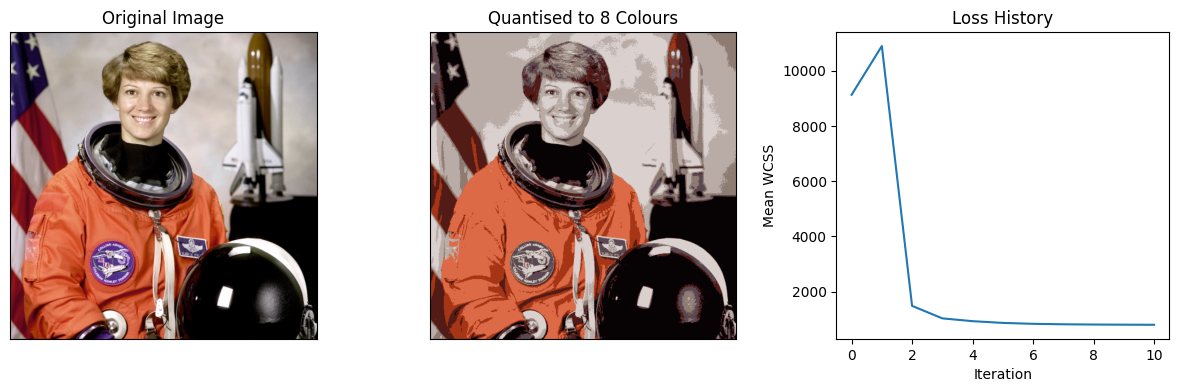

In [12]:
NUM_COLOURS = 8
astro = iio.imread('imageio:astronaut.png')

quant, loss = quantise_image(astro, NUM_COLOURS, max_iter=10)

fig = plt.figure(figsize=(12, 4))
axs = fig.subplots(ncols=3)

utils.plot_image(axs[0], astro, 'Original Image')
utils.plot_image(axs[1], quant, f'Quantised to {NUM_COLOURS} Colours')

axs[2].plot(loss)
axs[2].set_title('Loss History')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Mean WCSS')

fig.tight_layout(pad=1)

# Task 3: Principal Components Analysis

**Dimensionality reduction** techniques attempt to map data from its original space into a different, smaller one while retaining all or most of its meaningful variation. In general this entails finding relationships among the original feature dimensions that render some of those dimensions redundant: if one feature can be predicted from others then there is no need to record it in its own right.

Such relationships arise frequently from the constraints of the underlying physical reality from which the data is captured. Eg, as discussed last week in the context of CNNs, the neighbouring pixels in an image tend to be similar because they derive from nearby points in space, which are often part of the same object surface. Their values are thus not perfectly independent, and the data exhibits fewer true ("intrinsic") degrees of freedom than our naive ("ambient" or "extrinsic") feature representation.

Relationships such as those among pixels in images may be extremely complex and hard to fathom, and we're not going attempt to delve into them here. But data can often be constrained in ways that are — or at least can be reasonably well approximated as — fairly simple. In particular (and not for the first time): **linear**.

**Principal components analysis** (PCA) finds a linear projection of the original data into a new **orthonormal basis** in which:
* The first dimension captures as much of the original data variation as possible in a single dimension.
* The second dimension captures as much as possible of whatever variation is still left after the first.
* The third captures as much as possible of the remaining variation after the second.
* ... and so on.

This does not in itself reduce dimensionality — the new basis will have as many dimensions as the original. In the worst case, all of these dimensions will be fully exercised and we don't gain anything. But typically in real world data a lot of the variation can be captured in relatively few dimensions, with the contributions of each subsequent dimension adding less and less information. In that case, we can perform dimensionality reduction by simply throwing away — or never bothering to calculate — those less informative dimensions.

As discussed in the lectures, PCA is *the* other notable case (along with OLS/ridge regression) of a machine learning problem with an analytic solution. Indeed, there are two different (though closely related) such solutions, both of which you will implement below.

## 3.1 Centre the data

PCA is almost always done using centred data, which makes calculation of the covariance matrix (see Task 3.2, below) very simple. So we'll do that first here too.

Implement the `centre_data` function in the cell below. Return the vector of subtracted means as well as the centred design matrix so that the original location can be recovered.

In [13]:
def centre_data(X):
    """
    Offset all features to have zero mean, returning
    both the centred data and the removed intercepts
    for later recovery.

    # Arguments
        X: input design matrix of shape (num_samples, num_features)

    # Returns
        centred: design matrix of centred features, same shape as X
        intercepts: vector of subtracted means
    """

    # TODO: implement this
    #return None, None

    # --------

    intercepts = np.mean(X, axis=0)
    return X - intercepts, intercepts

## 3.2 Compute PCA by eigendecomposition of the covariance matrix

As shown in Lecture 7.3, the principal components of a dataset are simply the (right) **eigenvectors** of its covariance matrix. The corresponding **eigenvalues** give the contribution of each component to the overall variance of the data (often decribed as being how much of the variance they *explain*).

For centred data, the covariance matrix is simply:

$$\mathbf{\Sigma} = \frac{1}{n}\mathbf{X}^{\mathsf{T}}\mathbf{X}$$

where $n$ is the number of samples. (You can assume the data is centred here — we'll do that in Task 3.4.)

If $\mathbf{U}$ is a matrix whose columns are (some of) the right eigenvectors of $\mathbf{\Sigma}$, then you can map $\mathbf{X}$ onto those principal components by right multiplying:

$$
\tilde{\mathbf{X}} = \mathbf{XU}
$$

And you can transform it back by right multiplying with the transpose:

$$
\mathbf{X} = \mathbf{\tilde{X}U}^{\mathsf{T}}
$$

($\mathbf{U}$ is orthogonal, so $\mathbf{UU}^{\mathsf{T}} = \mathbf{U}^{\mathsf{T}}\mathbf{U} = \mathbf{I}$.)

Implement `pca_eigen` in the cell below to perform PCA using the eigenvectors of the covariance matrix. Eigenvectors and eigenvalues can be computed using [numpy.linalg.eig](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html). Note that the values returned from that function are not guaranteed to be sorted, so you'll need to sort them in descending order.

Return both the transformed data $\tilde{\mathbf{X}}$ and the principal components matrix $\mathbf{U}^{\mathsf{T}}$ so that we can readily transform the data back.

In [14]:
def pca_eigen(X, num_components=None):
    """
    Compute PCA by eigendecomposition and optionally reduce dimensionality.

    # Arguments:
        X: centred input data of shape (num_samples, num_features).
        num_components: number of principal components to retain.
           (Default is to keep them all.)

    # Returns:
        transformed: The transformed data, optionally truncated at n along the
            second dimension (shape (num_samples, num_components)).
        components: transposed matrix of components to use to map back to the,
            original space, of shape (num_components, num_features)
    """

    # TODO: implement this
    #return None, None

    # --------

    # compute eigendecomposition of covariance
    cov = (X.T @ X) / X.shape[0]
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # sort in decreasing order and keep the required number of columns
    components = eigenvectors[:, np.argsort(-eigenvalues)[:num_components]]

    # project
    transformed = X @ components

    return transformed, components.T

## 3.3 Compute PCA by singular value decomposition of the data matrix

An alternative way to compute the principal components is via **singular value decomposition** (SVD) of the original data matrix. This breaks the data down into three matrices:

$$\mathbf{X} = \mathbf{VDU}^{\mathsf{T}}$$

where $\mathbf{D}$ is **diagonal** and $\mathbf{U}$ is the same matrix of right eigenvectors as in the previous task. The projected data is then calculated as

$$\tilde{\mathbf{X}} = \mathbf{VD}$$

The transformation back remains the same:

$$
\mathbf{X} = \mathbf{\tilde{X}U}^{\mathsf{T}}
$$

SVD computation can be more efficient than determining the eigenvectors and tends to be preferred under the hood.

(**Important**: notation for these matrices varies confusingly between sources and they may be represented by other symbols. For example, in the NumPy documentation linked below they are denoted **U**, **S** and **Vh** — ie U and V are the other way around! Be aware of this in your implementation.)

Implement `pca_svd` in the cell below to perform PCA using SVD. You can do the decomposition with [numpy.linalg.svd](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html). A few of things to note about that function:
* You should set `full_matrices=False`, otherwise the results may be prohibitively slow and resource hungry for the image data we'll use for testing below.
* The singular values **S** are returned as a vector. Use [numpy.diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html) to create the matrix $\mathbf{D}$ to multiply to produce $\tilde{\mathbf{X}}$.
* The returned matrix of components **Vh** corresponds to $\mathbf{U}^{\mathsf{T}}$ above — ie, it is already transposed.

In [15]:
def pca_svd(X, num_components=None):
    """
    Compute PCA by singular value decomposition and optionally reduce dimensionality.

    # Arguments:
        X: centred input data of shape (num_samples, num_features).
        num_components: number of principal components to retain.
           (Default is to keep them all.)

    # Returns:
        transformed: The transformed data, optionally truncated at n along the
            second dimension (shape (num_samples, num_components)).
        components: transposed matrix of components to use to map back to the,
            original space, of shape (num_components, num_features)
    """

    # TODO: implement this
    #return None

    # --------

    # decompose
    v, d, u = np.linalg.svd(X, full_matrices=False)

    # expand the values to a diagonal matrix
    transformed = v @ np.diag(d)

    # project
    return transformed[:, :num_components], u[:num_components, :]

## 3.4 Reduce dimensionality and transform back to original data space

For many machine learning purposes, the transformed data matrix $\tilde{\mathbf{X}}$ is all you need — you can do classification or regression with it, for example, without ever needing to go back to the original data space. However, it can be useful to transform back just to get an idea of what is being kept and what is being lost when the dimensions are reduced.

Implement the function `pca_round_trip` in the code cell below to perform linear dimensionality reduction and then recover what's left of the data.

Most of this will just be calling the functions you've already written above. However, as with the colour quantisation in Task 2, we're going to use this on image data, so you'll need to reshape it into the design matrix format first, and then back to the original shape at the end.

You should also convert it back to the original `dtype`, but before doing so run the function provided in the `clean` argument on it. (Reducing the dimensionality will likely introduce out of range values that would create artefacts in the image otherwise.)

Don't forget to centre the data, and call the appropriate PCA function according to the `method` argument.

In [16]:
def pca_round_trip (data, num_components=None, method='svd', clean=lambda x: x):
    """
    Perform PCA, reduce dimensionality and then restore the
    data to its original form (with data loss).

    # Arguments
        data: array of (uncentred) data to be transformed. must be at least 2D,
            with last dimension containing features.
        num_components: number of principal components to keep
        method: how to perform the PCA, one of 'svd' or 'eig'
        clean: optional function to apply to the data before converting
            it back to its original dtype

    # Returns
        reduced: array of the same shape and dtype as the input, containing
            the data reconstructed from the PCA
    """

    # TODO: implement this
    #return None

    # --------

    # reshape and then centre the data
    X, offsets = centre_data(data.reshape(-1, data.shape[-1]))

    # call the appropriate PCA function
    transformed, components = pca_svd(X, num_components) if method=='svd' else pca_eigen(X, num_components)

    # restore the offsets and perform any supplied cleaning
    reduced = clean(transformed @ components + offsets)

    # restore to original shape and type
    return reduced.astype(data.dtype).reshape(data.shape)



## → Run Task 3

Run the cell below to perform PCA on the same astronaut image as in Task 2. How do the different components affect the image? If you run it multiple times, do you get different results? (You might be able to answer that without actually doing it.)

How do these results compare with the quantisation in Task 2? Which is faster, or more appealing, or achieves better compression? Would your answers change for different images?


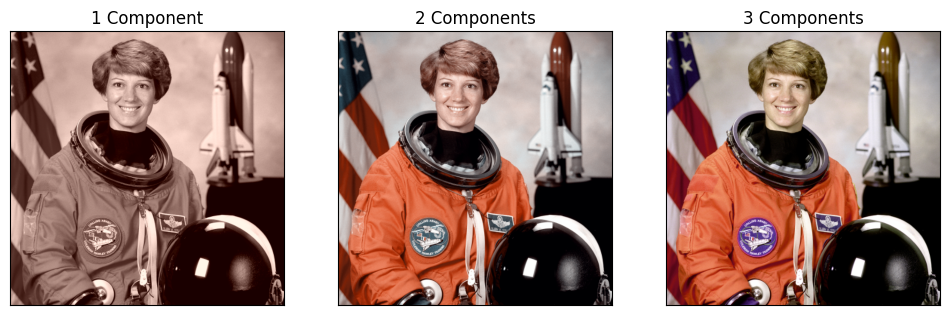

In [17]:
# keep pixel values in range
clean = lambda x: np.clip(x, 0, 255)

astro1 = pca_round_trip(astro, num_components=1, clean=clean)
astro2 = pca_round_trip(astro, num_components=2, clean=clean, method='eig')
astro3 = pca_round_trip(astro, num_components=3, clean=clean)

fig = plt.figure(figsize=(12, 4))
axs = fig.subplots(ncols=3)

utils.plot_image(axs[0], astro1, '1 Component')
utils.plot_image(axs[1], astro2, '2 Components')
utils.plot_image(axs[2], astro3, '3 Components')



# Further exploration

As usual, you don't need to do any of this, but if you're keen to play around more, here are some suggestions.

* Try out both clustering and PCA on other data sources.

  Note: if you want to use other images, [imageio](https://imageio.readthedocs.io/en/stable/) provides a number of [sample images](https://imageio.readthedocs.io/en/stable/user_guide/standardimages.html), and also makes it pretty easy to load one from a URL. Eg, this command gets a picture of **meerkats** from Wikipedia:

  ```python
  meerkat = iio.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/Meerkat_%28Suricata_suricatta%29_with_3_young.jpg/480px-Meerkat_%28Suricata_suricatta%29_with_3_young.jpg')
  ```

* Implement [$k$-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) initialisation as an alternative to `forgy` and `naive` in Task 1.2. Does it make a difference?
* In Task 3.4 the data was **centred** before applying PCA. What happens if you don't do this? Does it affect both methods in the same way?
* Try visualising the individual components that come out of PCA when used on image colours as in Task 3. What do they contain? Can you make sense of what they are doing?
* Have a look at [Non-negative Matrix Factorisation](https://scikit-learn.org/stable/modules/decomposition.html#non-negative-matrix-factorization-nmf-or-nnmf), which is implemented in SciKit-Learn. How would you expect this to differ from PCA in the case of image colours? Why might this be useful?
* We have only attempted linear dimensionality reduction here, but obviously lots of data has significantly non-linear structure. Have a look at [manifold learning](https://scikit-learn.org/stable/modules/manifold.html) methods such as [t-SNE](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne) (again implemented in SciKit-Learn). Would that be useful for the test data here? What kinds of problems might you apply it to?